## EXERCISE 0

Download and extract the Python version of the CIFAR dataset from the CIFAR website.  
The dataset is structured as follows:

- **5 training batches** of 10,000 images each (50,000 images total)  
- **1 test batch** of 10,000 images  

Each batch file contains a **dictionary** with the following elements:

- **`data`** – a 10,000 × 3,072 NumPy array of `uint8`.  
  Each row represents a 32×32 color image:  
  - The first 1,024 entries are the red channel,  
  - The next 1,024 entries are the green channel,  
  - The final 1,024 entries are the blue channel.  
  Images are stored in **row-major order**, i.e., the first 32 entries correspond to the red values of the first row of the image.

- **`labels`** – a list of 10,000 integers in the range 0–9.  
  The number at index `i` indicates the label of the `i`th image in `data`.

The dataset also contains another file called **`batches.meta`**, which is a Python dictionary with the following entry:

- **`label_names`** – a 10-element list giving meaningful names to the numeric labels in the `labels` array described above.  
  For example:  
  ```python
  label_names[0] == "airplane"
  label_names[1] == "automobile"
  # etc.


Number of training samples: 50000
Image shape: torch.Size([3, 32, 32]) Label: 6


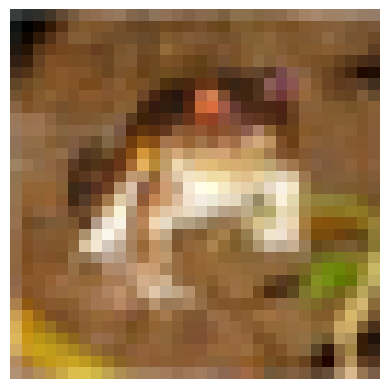

Label: 6


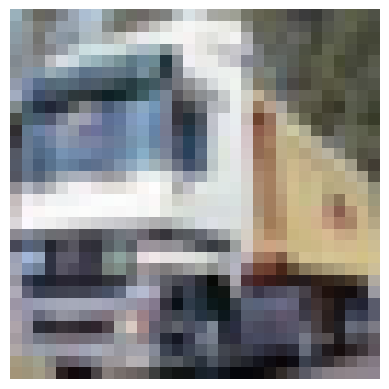

Label: 9


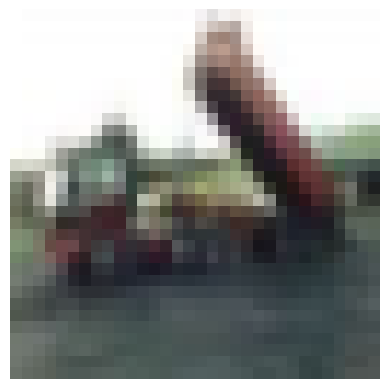

Label: 9


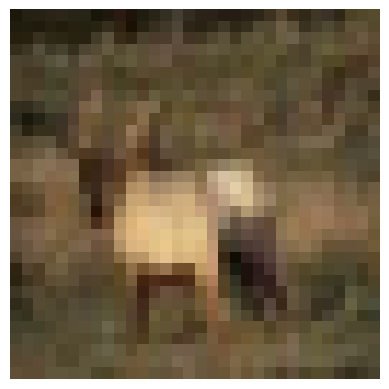

Label: 4


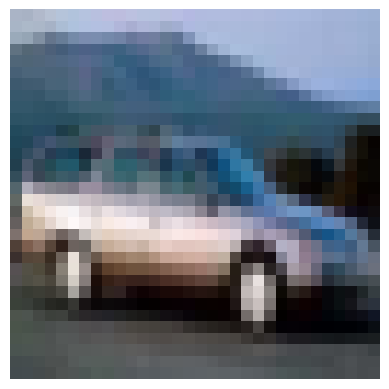

Label: 1


In [9]:
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CIFAR10Dataset(Dataset):
    def __init__(self, path, data_type='train', transform=None):
        """
        Args:
            path (str): path to the CIFAR-10 data files
            data_type (str): 'train' or 'test'
            transform (callable, optional): transformation to apply to each image
        """
        self.path = path
        self.transform = transform
        self.data = []
        self.labels = []

        if data_type == 'train':
            # load all 5 training batches
            for i in range(1, 6):
                file = f"{path}/data_batch_{i}"
                with open(file, 'rb') as fo:
                    batch = pickle.load(fo, encoding='bytes')
                    # reshape to (10000,3,32,32)
                    imgs = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                    self.data.append(imgs)
                    self.labels += batch[b'labels']
            self.data = np.vstack(self.data)  # shape (50000,3,32,32)
        elif data_type == 'test':
            file = f"{path}/test_batch"
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')
                self.data = np.reshape(batch[b'data'], (10000, 3, 32, 32))
                self.labels = batch[b'labels']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]  # CHW
        label = self.labels[index]

        # Convert CHW -> HWC for ToTensor
        img = np.transpose(img, (1, 2, 0))

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

    def visualize(self, img):
        """Visualize a single image (tensor or NumPy array)."""
        if isinstance(img, torch.Tensor):
            img = img.clone().detach()
            img = img.numpy()
            img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
            img = img * 0.5 + 0.5  # denormalize
        elif img.max() > 1.0:
            img = img / 255.0  # normalize if uint8

        plt.imshow(img)
        plt.axis('off')
        plt.show()


# ------------------------------
# Main: Instantiate and test
# ------------------------------

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # converts HWC uint8 image to CHW float tensor [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # normalize to [-1,1]
])

# Load the dataset
dataset = CIFAR10Dataset(path='data', data_type='train', transform=transform)

# Check dataset size
print("Number of training samples:", len(dataset))

# Get one sample
img, label = dataset[0]
print("Image shape:", img.shape, "Label:", label)

# Visualize first 5 images
for i in range(5):
    img, label = dataset[i]
    dataset.visualize(img)
    print("Label:", label)


## EXERCISE 2 
Build a CNN model to predict a class from the input image.